# Lab: Titanic Survival Exploration with Decision Trees

## Getting Started
In the introductory project, you studied the Titanic survival data, and you were able to make predictions about passenger survival. In that project, you built a decision tree by hand, that at each stage, picked the features that were most correlated with survival. Lucky for us, this is exactly how decision trees work! In this lab, we'll do this much quicker by implementing a decision tree in sklearn.

We'll start by loading the dataset and displaying some of its rows.

Recall that these are the various features present for each passenger on the ship:
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)  
- (Target variable) **Survived**: Outcome of survival (0 = No; 1 = Yes)  



In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # Import the classifier from sklearn
from sklearn.cross_validation import StratifiedKFold
from sklearn.base import clone # Import functionality for cloning a model
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

/anaconda/envs/dog-project/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/envs/dog-project/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

In [18]:
%matplotlib inline

In [20]:
# Load the dataset
data = pd.read_csv('titanic_data.csv')

# Print the first few entries of the Titanic data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
# define variables(features, outcomes)
#Note: do not include Name column with features 
outcomes = data['Survived']
features = data.drop(['PassengerId', 'Name', 'Survived'], axis = 1)



# Show the new dataset with 'Survived' removed
features.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 62.7+ KB


In [23]:
features.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')

In [24]:
features.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [25]:
features = features.fillna(0.0)
features.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,0,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,0,S


In [26]:
features.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

## Preprocessing the data


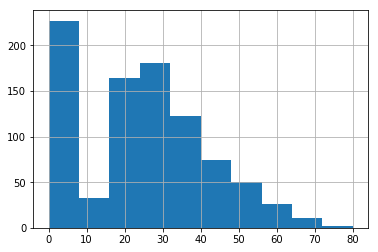

In [27]:
features.Age.hist();

In [28]:
#transformation: Perform feature scaling on the data
# first: define the standardization scaling object using StandardScaler().
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 


# second: apply the scaler to the numerical columns on the data:
numerical = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
features[numerical] = scaler.fit_transform(features[numerical])

features[numerical].head()


,Pclass,Age,SibSp,Parch,Fare
0,0.827377,-0.102313,0.432793,-0.473674,-0.502445
1,-1.566107,0.807492,0.432793,-0.473674,0.786845
2,0.827377,0.125138,-0.474545,-0.473674,-0.488854
3,-1.566107,0.636903,0.432793,-0.473674,0.420730
4,0.827377,0.636903,-0.474545,-0.473674,-0.486337


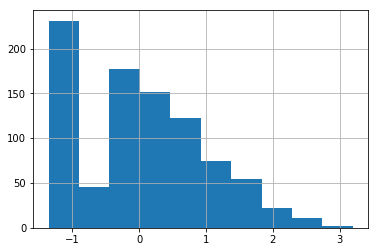

In [29]:
features.Age.hist();

we'll one-hot encode the features.

In [14]:
#dummies variables: convert catogrical columns to numerical
## perform one-hot encoding on categorical columns Using pandas.get_dummies()
features = pd.get_dummies(features)
features.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Ticket_110152,Ticket_110413,Ticket_110465,...,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_0.0,Embarked_C,Embarked_Q,Embarked_S
0,0.827377,-0.102313,0.432793,-0.473674,-0.502445,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-1.566107,0.807492,0.432793,-0.473674,0.786845,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.827377,0.125138,-0.474545,-0.473674,-0.488854,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-1.566107,0.636903,0.432793,-0.473674,0.420730,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.827377,0.636903,-0.474545,-0.473674,-0.486337,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
features.shape

(891, 840)

In [16]:
#extra point:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html
# use SelectPercentile to reduce the features number and select the importances features
selector = SelectPercentile(f_classif, percentile=60)
selector.fit(features, outcomes)
features = selector.transform(features)
features.shape

(891, 504)

## Training the model

Now we're ready to train a model in sklearn. First, let's split the data into training and testing sets. Then we'll train the model on the training set.

In [156]:
#split the data to two sets. training set and testing set:
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2, random_state=42)

In [157]:
# Define the classifier model as DecisionTree
model = DecisionTreeClassifier()


#fit the model to the data
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Testing the model
Now, let's see how our model does, let's calculate the accuracy over both the training and the testing set.

In [158]:
# Making predictions on scaling data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 1.0
The test accuracy is 0.8212290502793296


# Improving the model

Ok, high training accuracy and a lower testing accuracy. We may be overfitting a bit.

So now it's your turn to shine! Train a new model, and try to specify some parameters in order to improve the testing accuracy, such as:
- `max_depth` The maximum number of levels in the tree.
- `min_samples_leaf` The minimum number of samples allowed in a leaf.
- `min_samples_split` The minimum number of samples required to split an internal node.



use Grid Search!



In [68]:
#grid search
#import gridsearch
from sklearn.model_selection import GridSearchCV

#set the classifier model
clf = DecisionTreeClassifier(random_state=40)
#set the parameters:
parameters = {'max_depth': [5, 6, 7,8, 9, 10], 'min_samples_leaf': [2, 3, 4, 5, 6], 'min_samples_split': [5, 6, 7, 8, 9, 10]}
#define the score method using make_scorer()
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
scorer = make_scorer(accuracy_score)

#define gridsearchcv function with cv=3
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=3)
#fit/ train the function/ object
grid_fit = grid_obj.fit(X_train, y_train)
#get the best estimtor model
best_clf = grid_fit.best_estimator_

# Make predictions using the new model.
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

In [69]:
# Calculating accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.8651685393258427
The test accuracy is 0.8491620111731844


In [34]:
#print the setting of the best model
best_clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=40, splitter='best')

In [126]:
#Extra point: copy the "best" model found from grid search earlier to new model
from sklearn.base import clone # Import functionality for cloning a model
model = clone(best_clf)
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=40, splitter='best')